In [2]:
import sys
import os

sys.path.append(os.getcwd())

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter, autocorrelation_chain, process_chain, integrated_time
from refnx.reflect import SLD, ReflectModel, MixedReflectModel, MixedSlab, Slab, Structure
import MixedMagSlabs2
from vfp_M2 import VFP
import refnx
import scipy
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pickle
import copy
from uravu.distribution import Distribution

In [3]:
class LogpExtra(object):
    def __init__(self, pars):
        # we'll store the parameters and objective in this object
        # this will be necessary for pickling in the future
        self.pars = pars

    def __call__(self, model, data):
        if (float(self.pars[0]-2*self.pars[1]) >= 0 and float(self.pars[2]-2*self.pars[3]) >= 0 and float(self.pars[6]) >= 0 and float(self.pars[6]) <= 1 
        and float(self.pars[4]-2*self.pars[5]) >= 0 and float(self.pars[7]) >= 0 and float(self.pars[7]) <= 1):
            return 0
        return -1E15

In [4]:
with open(os.path.join(os.getcwd(), 'M2_FIT_GO.pkl'),"rb") as f:
    GO = pickle.load(f)

In [5]:
#plot median volume fractions.
GMO_vol_frac_head_median = GO.varying_parameters()[0] #defined without including solvation.
GMOav_vol_frac_tail_median = GO.varying_parameters()[1] #defined without including solvation.
head_solvation_median = GO.varying_parameters()[2]
solvation_median = GO.varying_parameters()[3]
SiO2_thick_median = GO.varying_parameters()[4]
SiO2_Fe_R_median = GO.varying_parameters()[5]
Fe_thick_median = GO.varying_parameters()[6]
Fe_SLD_median = GO.varying_parameters()[7]
Fe_magmom_median = GO.varying_parameters()[8]
FeOx_Fe_R_median = GO.varying_parameters()[9]
FeOx_SLD_median = GO.varying_parameters()[10]
FeOx_thick_median = GO.varying_parameters()[11]
FeOx_m_median = GO.varying_parameters()[12]
FeOx_R_median = GO.varying_parameters()[13]
GMO_head_thick_median = GO.varying_parameters()[14]
GMO_head_rough_median = GO.varying_parameters()[15]
GMO_tail_thick_median = GO.varying_parameters()[16]
GMO_tail_rough_median = GO.varying_parameters()[17]
dd_d2o_sld_median = GO.varying_parameters()[18]
dd_h2o_sld_median = GO.varying_parameters()[19]
GMO_head_median = GO.varying_parameters()[20]

In [7]:
#can calculate this using the pdf of the Fe volume fraction.
#The pdf describes how the number of Fes change per Z value.
#we then want to know the probability that the additional Fes at a given Z came from Si.
#The probability of Si vs SiO2 is given by 1-cdf of SiO2.
#We therefore multiply the pdf of Fe number by the 1-cdf of SiO2.
#This tells us the total number of Fes that have flipped from Si at each Z.
#Take the sum (integrate) to calculate the fraction of Si flips to Fe vs Si to SiO2.

from scipy.stats import norm

target_Si = (norm.pdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=float(SiO2_thick_median), scale=float(SiO2_Fe_R_median))*(1-norm.cdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=0, scale=3)))
target_SiO2 = (norm.pdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=float(SiO2_thick_median), scale=float(SiO2_Fe_R_median))*(norm.cdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=0, scale=3)))

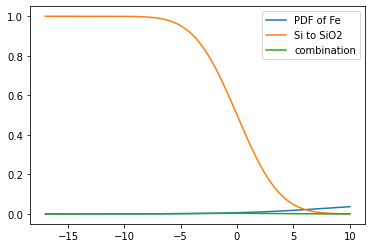

In [8]:
plt.plot(np.linspace(-17, 10, (10*(10+17)+1)), norm.pdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=float(SiO2_thick_median), scale=float(SiO2_Fe_R_median)), label='PDF of Fe')
plt.plot(np.linspace(-17, 10, (10*(10+17)+1)), (1-norm.cdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=0, scale=3)), label='Si to SiO2')
plt.plot(np.linspace(-17, 10, (10*(10+17)+1)), target_Si, label='combination')
plt.legend()

In [622]:
#The total of Target_Si and Target_SiO2 equals the total fraction of Fe at z = 10.

#fraction of Fe that was flipped from Si as z increases. (i.e the area of Si/Fe interface without SiO2)
print(np.trapz(target_Si, x=np.linspace(-17, 10, (10*(10+17)+1)))) 

#fraction of Fe flipped from SiO2 as z increases. (total area of SiO2/Fe interface.)
print(np.trapz(target_SiO2, x=np.linspace(-17, 10, (10*(10+17)+1))))

#do these individual components add up to the total change to Fe?
print(np.trapz(target_Si, x=np.linspace(-17, 10, (10*(10+17)+1))) + np.trapz(target_SiO2, x=np.linspace(-17, 10, (10*(10+17)+1))))
print(norm.cdf(np.linspace(-17, 10, (10*(10+17)+1)), loc=float(SiO2_thick_median), scale=float(SiO2_Fe_R_median))[-1])

0.027033846671061856
0.18494907030448163
0.21198291697554347
0.21199324675611986


In [27]:
#repeat for Fe to Inner/Outer/Solv

Fe_centre = SiO2_thick_median+Fe_thick_median
FeOx_centre = SiO2_thick_median+Fe_thick_median+FeOx_thick_median
Inner_centre = SiO2_thick_median+Fe_thick_median+FeOx_thick_median+GMO_head_thick_median

#target_not_FeOx = pdf of Fe * cdf of inner/outer/solv.
target_not_FeOx = norm.pdf(np.linspace(170, 300, (10*(300-170)+1)), loc=float(Fe_centre), scale=float(FeOx_Fe_R_median))*norm.cdf(np.linspace(170, 300, (10*(300-170)+1)), loc=FeOx_centre, scale=FeOx_R_median)
target_FeOx = norm.pdf(np.linspace(170, 300, (10*(300-170)+1)), loc=float(Fe_centre), scale=float(FeOx_Fe_R_median))*(1-norm.cdf(np.linspace(170, 300, (10*(300-170)+1)), loc=FeOx_centre, scale=FeOx_R_median))

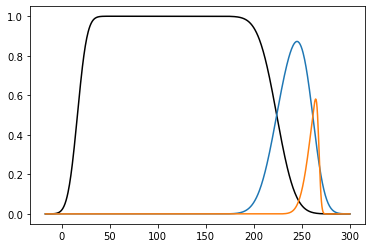

In [28]:
%matplotlib inline
#plt.plot(np.linspace(170, 300, (10*(300-170)+1)), norm.cdf(np.linspace(170, 300, (10*(300-170)+1)), loc=FeOx_centre, scale=FeOx_R_median))
plt.plot(GO.objectives[0].model.structures[0].components[1].get_x_and_y_scatter()[0], GO.objectives[0].model.structures[0].components[1].vfs_for_display()[2].T, color='k')
plt.plot(GO.objectives[0].model.structures[0].components[1].get_x_and_y_scatter()[0], GO.objectives[0].model.structures[0].components[1].vfs_for_display()[3].T)
plt.plot(GO.objectives[0].model.structures[0].components[1].get_x_and_y_scatter()[0], GO.objectives[0].model.structures[0].components[1].vfs_for_display()[4].T)

In [31]:
# the number of Fe to Inner flips.
Fe_to_not_FeOx = np.trapz(target_not_FeOx, x=np.linspace(170, 300, (10*(300-170)+1))) 

In [32]:
# the number of Fe to FeOx flips.
Fe_to_FeOx = np.trapz(target_FeOx, x=np.linspace(170, 300, (10*(300-170)+1))) 

In [33]:
print(Fe_to_not_FeOx)
print(Fe_to_FeOx)
print(Fe_to_not_FeOx+Fe_to_FeOx)

0.01938159120041028
0.9804246728020731
0.9998062640024834
